<a href="https://colab.research.google.com/github/QI-N-QIGT/lenet5/blob/master/My_lenet5_to_CIFAR10_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install some necessary libraries.

In [ ]:
pip install hiddenlayer  # a kind of visualable tool

### The first part is to download the cifar10 dataset and process it. We can download it from torchvision.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# detect whether the GPU is existed.
print(device)

cuda:0


In [ ]:
import numpy as np
# load data
from torchvision import datasets
# load the training data

### Calculate the mean and std of CIFAR10

In [ ]:
train_data = datasets.CIFAR10('./cifar10_data', train=True, download=True)
test_data = datasets.CIFAR10('./cifar10_data_test', train=False, download=True)
print(f"lenght of test_data is: {len(test_data)}")
print(f"lenght of train_data is: {len(train_data)}")
print(np.asarray(train_data[1][0]).shape)

# use np.concatenate to stick all the images together to form a 1600000(50000*32) X 32 X 3 array
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
# print(x)
print(x.shape)
# calculate the mean and std along the (0, 1) axes
train_mean = np.mean(x, axis=(0, 1)) / 255
train_std = np.std(x, axis=(0, 1)) /255
# the the mean and std
print(train_mean, train_std)

(1600000, 32, 3)
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


### Preprocess the data
1. Converts a PIL.Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
2. tansforms.Normalize is to set the distribution into stand normal one
3. transform.Compose is to compose the several tranform operations.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262])])
dataset_cifar10_train = torchvision.datasets.CIFAR10(root="./cifa10_data", train = True, transform = transform, download = True)
dataset_cifar10_test = torchvision.datasets.CIFAR10(root="./cifa10_data", train = False, transform = transform, download = True)
class_10_name = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./cifa10_data/cifar-10-python.tar.gz to ./cifa10_data
Files already downloaded and verified


### We just need prepare the data for training using DataLoaders

In [ ]:
from torch.utils.data import DataLoader
batch_size = 50

train_dataloader = DataLoader(dataset_cifar10_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_cifar10_test, batch_size=batch_size, shuffle=True)

### Display the figures to check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([50, 3, 32, 32])
Labels batch shape: torch.Size([50])
torch.Size([32, 32, 3])
Label: car


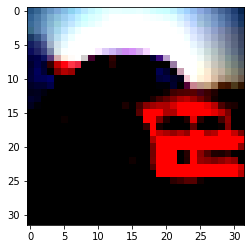

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = torch.transpose(img, 0, 1)
img = torch.transpose(img, 1, 2)
print(img.shape)
torch.transpose(img,1,2)
label = train_labels[0]
plt.imshow(img)
print(f"Label: {class_10_name[label]}")

### I think I have prepared the train data well, and then I will build the NN structure.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# we use the classical CNN that is lenet-5

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(3, 6, 5)
      self.maxpool2 = nn.MaxPool2d(2,2)
      self.conv3 = nn.Conv2d(6,16,5)
      self.maxpool4 = nn.MaxPool2d(2,2)
      self.dense5 = nn.Linear(16*5*5,120) # self.conv5 = nn.Linear(16,120,5) is OK. 
      self.dense6 = nn.Linear(120,84)
      self.dense7 = nn.Linear(84,10)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.maxpool2(x)
      x = F.relu(self.conv3(x))
      x = self.maxpool4(x)        # the dimmentions of x is [batch_size, 16, 5, 5]
      x = x.view(-1, 16*5*5)      # this command is used to compose the conv layer and linear layer,and the second aixs num is 16*5*5
      x = F.relu(self.dense5(x))  # the dimmentions of x is [16*5*5,120]
      x = F.relu(self.dense6(x))
      x = self.dense7(x)
      return x

### OK, I think I have bulit the lenet5 structure. Then I will begain train the neural network.

In [ ]:
lenet5_net = Net()
lenet5_net = lenet5_net.to(device)
print(lenet5_net)
# we have to define the loss function and optimization
loss_fun = nn.CrossEntropyLoss()
opt = torch.optim.SGD(lenet5_net.parameters(), lr = 0.001, momentum = 0.9)

### This is a more complete function with loss and accuracy output 

In [ ]:
import time
import hiddenlayer as hl

# I am trying to add the calculation of accuracy into the code
def train_process(model, epoch, loss_fun, optimizer, train_dataloader,test_dataloader):
  best_acc = 0.0

  for i in range(epoch):

    print('Epoch {}/{}'.format(i+1, epoch))
    print("*" * 30)
    # there are two phases in train processes
    for modes in ["train","val"]:
      running_loss = 0
      temp_loss = 0
      temp_correction = 0
      running_correction = 0
      if modes is "train":
        model.train() 
        for index, input_data in enumerate(train_dataloader, 0):
          # get the images and speed up by cuda
          imgs, labels = input_data
          imgs, labels = imgs.to(device), labels.to(device)
          # set the gradients all to zero
          opt.zero_grad() 

          with torch.set_grad_enabled(modes == "train"):
            # forwar & backward & optimization
            outputs = model(imgs)
            loss = loss_fun(outputs, labels)
            loss.backward()
            opt.step()
          running_loss += loss.item()  # transfer a tensor with one element to a number
          temp_loss += loss.item()
          running_correction += (torch.max(outputs,1).indices == labels).sum().item()
          temp_correction += (torch.max(outputs,1).indices == labels).sum().item()
          epoch_loss = running_loss / len(train_dataloader)
          epoch_acc = float(running_correction) / len(dataset_cifar10_train)
          if (index+1) % 250 == 0:
            print('[%d, %5d] train loss: %.3f' % (i + 1, index + 1, temp_loss / 250))
            print('[%d, %5d] train acc: %.3f' % (i + 1, index + 1, temp_correction / (250*batch_size)))
            temp_loss = 0
            temp_correction = 0
          # print(f"{modes} Loss: {epoch_loss}, acc: {epoch_acc}")

      elif modes is "val":
        model.eval()
        for index, test_data in enumerate(test_dataloader, 0):
          # get the images and speed up by cuda
          imgs, labels = test_data
          imgs, labels = imgs.to(device), labels.to(device) 
          # set the gradients all to zero
          opt.zero_grad() 
          with torch.set_grad_enabled(modes == "train"):
            # forward 
            outputs = model(imgs)
            loss = loss_fun(outputs, labels)
          running_loss += loss.item()  # transfer a tensor with one element to a number
          temp_loss += loss.item()  # transfer a tensor with one element to a number
          running_correction += (torch.max(outputs,1).indices == labels).sum().item()
          temp_correction += (torch.max(outputs,1).indices == labels).sum().item()
          epoch_loss = running_loss / len(test_dataloader)
          epoch_acc = float(running_correction) / len(dataset_cifar10_test)
          if (index+1) % 50 == 0:
            print('[%d, %5d] train loss: %.3f' % (i + 1, index + 1, temp_loss / 50))
            print('[%d, %5d] train acc: %.3f' % (i + 1, index + 1, temp_correction / (50*batch_size)))
            temp_loss = 0
            temp_correction = 0

          #print(f"{modes} Loss: {epoch_loss}, acc: {epoch_acc}")
          if epoch_acc > best_acc:
            best_acc = epoch_acc


      if modes is "train":
        print(f"{modes} Loss: {epoch_loss}, acc: {epoch_acc}")
      elif modes is "val":
        print(f"{modes} Loss: {epoch_loss}, acc: {epoch_acc}")

    print("*"*30)

  print(f"best_acc is {best_acc}")          
  print("trainning finished")

In [ ]:
train_process(model = lenet5_net, epoch=20, loss_fun=loss_fun, optimizer = opt, train_dataloader = train_dataloader,test_dataloader=test_dataloader)

Epoch 1/20
******************************
[1,   250] train loss: 0.375
[1,   250] train acc: 0.866
[1,   500] train loss: 0.395
[1,   500] train acc: 0.857
[1,   750] train loss: 0.424
[1,   750] train acc: 0.844
[1,  1000] train loss: 0.428
[1,  1000] train acc: 0.848
train Loss: 0.405366850450635, acc: 0.8538
[1,    50] train loss: 1.506
[1,    50] train acc: 0.636
[1,   100] train loss: 1.500
[1,   100] train acc: 0.634
[1,   150] train loss: 1.526
[1,   150] train acc: 0.608
[1,   200] train loss: 1.490
[1,   200] train acc: 0.634
val Loss: 1.5053382363915444, acc: 0.6277
******************************
Epoch 2/20
******************************
[2,   250] train loss: 0.355
[2,   250] train acc: 0.876
[2,   500] train loss: 0.386
[2,   500] train acc: 0.864
[2,   750] train loss: 0.416
[2,   750] train acc: 0.851
[2,  1000] train loss: 0.423
[2,  1000] train acc: 0.848
train Loss: 0.3948166609406471, acc: 0.85958
[2,    50] train loss: 1.460
[2,    50] train acc: 0.637
[2,   100] tra

In [ ]:
def train(epoch, train_dataloader):

  for i in range(epoch):
    total_loss = 0
    for index, input_data in enumerate(train_dataloader, 0):
      # get the images and speed up by cuda
      input_imgs, input_labels = input_data
      input_imgs, input_labels = input_imgs.to(device), input_labels.to(device)
      # set the gradients all to zero
      opt.zero_grad()

      # forwar & backward & optimization
      # now I am not very sure about the functions of optimazation
      outputs = lenet5_net(input_imgs)
      loss = loss_fun(outputs, input_labels)
      loss.backward()
      opt.step()

      total_loss += loss.item()  # transfer a tensor with one element to a number
      if index % 200 == 199:
        print('[%d, %5d] loss: %.3f' %
                  (i + 1, index + 1, total_loss / 2000))
        total_loss = 0
               
  print("trainning finished")

In [ ]:
train(epoch=epoch, train_dataloader = train_dataloader)

### save the trained model

In [ ]:
model_path = "./lenet5_model.pth"
torch.save(lenet5_net.state_dict(),model_path)

### The next part is to validate the accuracy of this model.


In [ ]:
def validation(test_dataloader, model_path):

  correct_num = 0
  total_num = 0
  net = Net()
  net = net.to(device)
  net.load_state_dict(torch.load(model_path))
  for index, test_data in enumerate(test_dataloader, 0):

    # get the images and speed up by cuda
    test_imgs, test_labels = test_data
    test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)

    # forward
    outputs = net(test_imgs)
    
    correct_num += (torch.max(outputs,1).indices == test_labels).sum().item()
    total_num += list(test_labels.shape)[0]

    accuracy = (correct_num / total_num) * 100
  print(f"the accuracy in test_data is {accuracy}%")


In [ ]:
validation(test_dataloader, model_path)

the accuracy in test_data is 64.66%


### The classification process using lenet5 based on CIFAR10 has been completed, and then I want to explore the visualable problem during training.

In [ ]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('./Result')   # 数据存放在这个文件夹
loss = 10   # 第0层
for i, (name, param) in enumerate(lenet5_net.named_parameters()):
    if 'bn' not in name:
        writer.add_histogram(name, param, 0)
        writer.add_scalar('loss', loss, i)
        loss = loss*0.5

### Connect the google drive and colab. Therefore, I can save the data to the Google drive.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive"
os.chdir(path)
os.listdir(path)

### Visualable tools

In [ ]:
 # 导出网络结构图
 import hiddenlayer as hl
 vis_graph = h.build_graph(lenet5_net, torch.zeros([1, 3, 32, 32]).to(device))   # 获取绘制图像的对象
 vis_graph.theme = h.graph.THEMES["blue"].copy()     # 指定主题颜色
 vis_graph.save(path+"/demo1.png")   # 保存图像的路径

### This function is modified to have the ability to show the loss and accuracy curves

In [ ]:
import time
import hiddenlayer as hl

# I am trying to add the calculation of accuracy into the code
### I think the loss function in the train_process function has a few mistakes
def train_process(model, epoch, loss_fun, optimizer, train_dataloader,test_dataloader):
  
  history_train = hl.History()
  canvas_train = hl.Canvas()
  history_test = hl.History()
  canvas_test = hl.Canvas()

  best_acc = 0.0
  steps_test = 0
  steps_train = 0
  for i in range(epoch):

    print('Epoch {}/{}'.format(i+1, epoch))
    print("*" * 30)
    # there are two phases in train processes
    for modes in ["train","val"]:
      running_loss = 0
      temp_loss = 0
      temp_correction = 0
      running_correction = 0
      if modes is "train":
        model.train() 
        for index, input_data in enumerate(train_dataloader, 0):
          # get the images and speed up by cuda
          imgs, labels = input_data
          imgs, labels = imgs.to(device), labels.to(device)
          # set the gradients all to zero
          opt.zero_grad() 

          with torch.set_grad_enabled(modes == "train"):
            # forwar & backward & optimization
            outputs = model(imgs)
            loss = loss_fun(outputs, labels)
            loss.backward()
            opt.step()
          running_loss += loss.item()  # transfer a tensor with one element to a number
          temp_loss += loss.item()
          running_correction += (torch.max(outputs,1).indices == labels).sum().item()
          temp_correction += (torch.max(outputs,1).indices == labels).sum().item()
          epoch_loss = running_loss / len(train_dataloader)
          epoch_acc = float(running_correction) / len(dataset_cifar10_train)
          steps_train = (index + 1) + len(train_dataloader) * i
          if steps_train % 250 == 0:
            # print('[%d, %5d] train loss: %.3f' % (i + 1, index + 1, temp_loss / 250))
            # print('[%d, %5d] train acc: %.3f' % (i + 1, index + 1, temp_correction / (250*batch_size)))
            # history_train.log(steps_train,loss = temp_loss / 250, accuracy=temp_correction / (250*batch_size))
            # canvas_train.draw_plot([history_train["loss"], history_train["accuracy"]])   
            # time.sleep(0.1)
            temp_loss = 0
            temp_correction = 0
          # print(f"{modes} Loss: {epoch_loss}, acc: {epoch_acc}")

      elif modes is "val":
        model.eval()
        for index, test_data in enumerate(test_dataloader, 0):
          # get the images and speed up by cuda
          imgs, labels = test_data
          imgs, labels = imgs.to(device), labels.to(device) 
          # set the gradients all to zero
          opt.zero_grad() 
          with torch.set_grad_enabled(modes == "train"):
            # forward 
            outputs = model(imgs)
            loss = loss_fun(outputs, labels)
          running_loss += loss.item()  # transfer a tensor with one element to a number
          temp_loss += loss.item()  # transfer a tensor with one element to a number
          running_correction += (torch.max(outputs,1).indices == labels).sum().item()
          temp_correction += (torch.max(outputs,1).indices == labels).sum().item()
          epoch_loss = running_loss / len(test_dataloader)
          epoch_acc = float(running_correction) / len(dataset_cifar10_test)
          steps_test = (index + 1) + len(test_dataloader) * i
          if steps_test % 50 == 0:
            print('[%d, %5d] train loss: %.3f' % (i + 1, index + 1, temp_loss / 50))
            print('[%d, %5d] train acc: %.3f' % (i + 1, index + 1, temp_correction / (50*batch_size)))
            history_test.log(steps_test, loss = temp_loss / 50, accuracy=temp_correction / (50*batch_size))
            canvas_test.draw_plot([history_test["loss"], history_test["accuracy"]])
            time.sleep(0.1)
            temp_loss = 0
            temp_correction = 0

          #print(f"{modes} Loss: {epoch_loss}, acc: {epoch_acc}")
          if epoch_acc > best_acc:
            best_acc = epoch_acc

      if modes is "train":
        print(f"{modes} Loss: {epoch_loss}, acc: {epoch_acc}")
      elif modes is "val":
        print(f"{modes} Loss: {epoch_loss}, acc: {epoch_acc}")

    print("*"*30)

  print(f"best_acc is {best_acc}")          
  print("trainning finished")

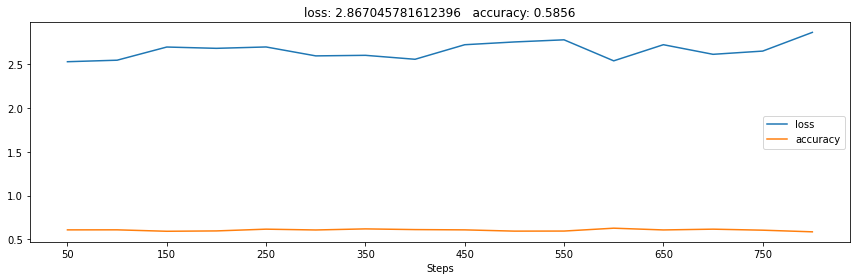

val Loss: 2.7154924923181536, acc: 0.6033
******************************
best_acc is 0.6133
trainning finished


In [ ]:
train_process(model = lenet5_net, epoch=4, loss_fun=loss_fun, optimizer = opt, train_dataloader = train_dataloader,test_dataloader=test_dataloader)